In [87]:
import numpy as np
import matplotlib.pyplot as plt
from warnings import filterwarnings
filterwarnings('ignore')
plt.rcParams.update({'font.size': 18})

CFL:  0.05


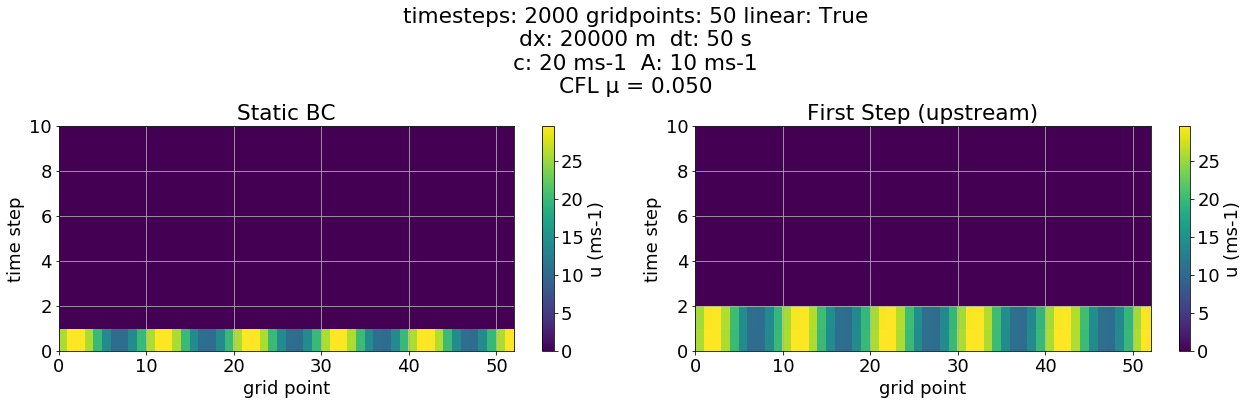

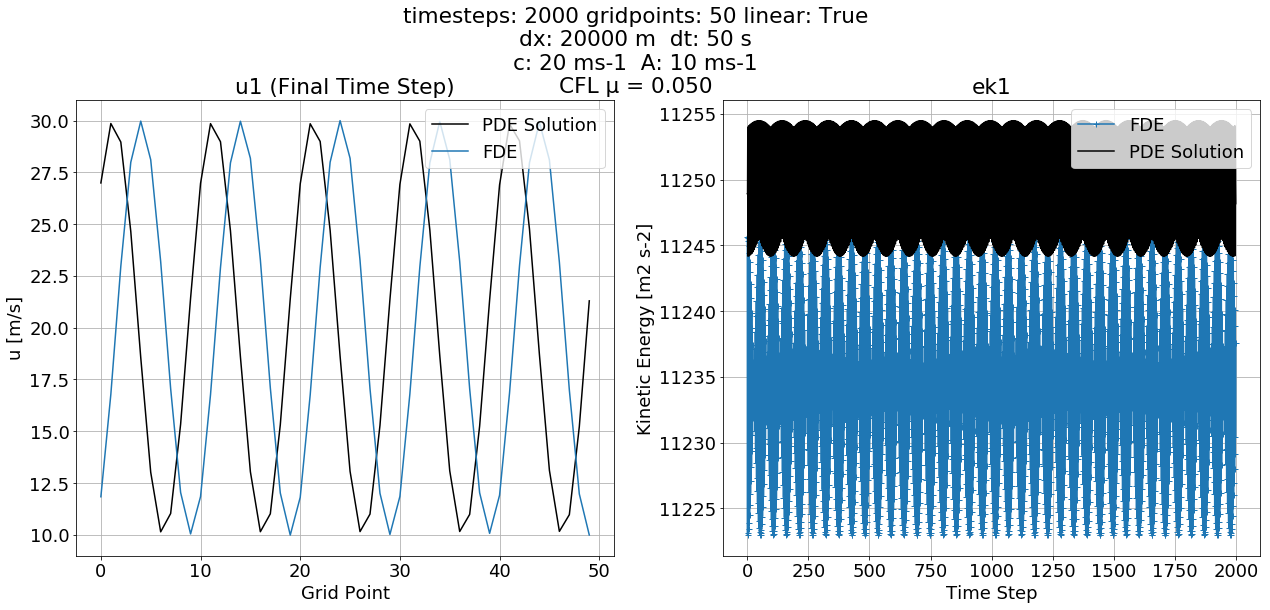

In [149]:
linear = True

# Establish constants
pi = 3.14

dx = 20 * 1e3 # m 
dt = 50 # s

c = 20. # ms-1
A = 10. # ms-1

L = 10. * dx
k = (2. * pi) / L

m = 2000 # number of time steps
n = 50  # number of grid points
_n = n+2

# For stability: 0 < mu < 1
mu = c * (dt / dx)
print('CFL: ', mu)

u1 = np.zeros(shape=(m, _n))

u1[0, 1:-1] = c + (A * np.sin(k * dx * np.arange(2, n+2)))
u1[0, 0] = u1[0, -2]
u1[0, -1] = u1[0, 1] 

# Plot the IC
fig, ax = plt.subplots(1, 2, figsize=(18, 6), facecolor='w')
fig.subplots_adjust(wspace=0.10)
_u1 = u1.copy()
cb = ax[0].pcolormesh(_u1)
ax[0].set_title('Static BC')
plt.colorbar(cb, ax=ax[0], label='u (ms-1)')
for axi in ax:
    axi.set_xlabel('grid point')
    axi.set_ylabel('time step')
    axi.set_ylim(0, 10)
    axi.grid(True)
    
j = slice(1, -1)
_c = c if linear else c + u1[0, j]
u1[1, j] = u1[0, j] - (_c * dt * (u1[0, j] - u1[0, slice(0, -2)]) / dx)
u1[1, 0] = u1[1, -2]
u1[1, -1] = u1[1, 1] 

ax[1].set_title('First Step (upstream)')
cb = ax[1].pcolormesh(u1)
plt.colorbar(cb, ax=ax[1], label='u (ms-1)')
ax[1].grid(True)

configs = 'timesteps: %d gridpoints: %d linear: %s\ndx: %d m  dt: %d s\nc: %d ms-1  A: %d ms-1\n'%(m, n, linear, dx, dt, c, A)
fig.suptitle(configs + u"CFL \u03bc = %.3f"%mu)
fig.tight_layout(rect=[0, 0.03, 1, 0.80])
plt.show()

for i in range(2, m):
    for j in range(1, n+1):
        
        # Time Integrate with Leapfrog Scheme
        _c = c if linear else c + u1[i-1, j]
        u1[i, j] = u1[i-2, j] - (_c * dt * ( u1[i-1, j+1] - u1[i-1, j-1] ) / dx)
        
    # Loop the periodic BC
    # (j is grid point, i is time step)
    u1[i, 0] = u1[i, -2]
    u1[i, -1] = u1[i, 1]
    
# Trim out the periodic placeholders
u1 = u1[:, 1:-1]

# Calculate Kinetic Energy at each time step
_ek1 = 0.5 * (u1**2)
ek1 = np.sum(_ek1, axis=1)

# Exact Solution
u = np.empty(u1.shape)
for t in range(u.shape[0]):
    for x in range(u.shape[1]):
        _x, _t, w = (x)*dx, (t)*dt, 1/c
        u[t, x] = c + (A * np.sin((w*_t) - (k*_x)))  
        
_ek = 0.5 * (u**2)
ek = np.sum(_ek, axis=1)

# Create the plots
fig, axs = plt.subplots(1, 2, figsize=(18,18/2), facecolor='w')
fig.subplots_adjust(hspace=0.45, wspace=0.45)
axs = axs.flatten()
axs = [None, None, axs[0], axs[1]]

# axs[0].pcolormesh(u1.T)
# axs[0].set_xlabel('Time Step')
# axs[0].set_ylabel('Grid Point')
# axs[0].set_title('u1 Hovmoller')

# axs[1].pcolormesh(_ek1.T)
# axs[1].set_xlabel('Time Step')
# axs[1].set_ylabel('Grid Point')
# axs[1].set_title('ek1 Hovmoller')

axs[2].plot(u[-1, :], c='k', label='PDE Solution')
axs[2].plot(u1[-1, :], label='FDE')
axs[2].set_xlabel('Grid Point')
axs[2].set_ylabel('u [m/s]')
axs[2].set_title('u1 (Final Time Step)')
axs[2].legend(loc='upper right')

axs[3].plot(np.arange(len(ek1)), ek1, '-+', label='FDE')
axs[3].plot(np.arange(len(ek1)), ek, c='k', label='PDE Solution')
axs[3].set_xlabel('Time Step')
axs[3].set_ylabel('Kinetic Energy [m2 s-2]')
axs[3].set_title('ek1')
axs[3].legend(loc='upper right')

[ax.grid(True) for ax in axs[2:]]

configs = 'timesteps: %d gridpoints: %d linear: %s\ndx: %d m  dt: %d s\nc: %d ms-1  A: %d ms-1\n'%(m, n, linear, dx, dt, c, A)
fig.suptitle(configs + u"CFL \u03bc = %.3f"%mu)
fig.tight_layout(rect=[0, 0.03, 1, 0.9])
plt.show()

# Write kinetic energy at every 50th time step to file
with open('./ek1.csv', 'w+') as wfp:
    for t, v in zip(np.arange(1, m+1)[::-50][::-1], ek1[::-50][::-1]):
        wfp.write('%d, %f\n'%(t, v))